In [1]:
TPU_NAME = 'moon-v3'
ZONE = 'eu'
TRAIN_IMAGE_SIZE = 256
BACKBONE = 'efficientnetb7'
THRESHOLD = 0.5
LEARNING_RATE = 1e-2
BATCH_SIZE = 8 * 32
EPOCHS = 100
STEPS_PER_EPOCH = 1000

In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


In [3]:
def get_mask_path(img_path):
  filename = os.path.basename(img_path)
  path = os.path.join(BASE_PATH, 'masks', filename)
  return path


def decode(img_path, numpy=False):
  """Decode a PNG image file"""
  bytes_ = tf.io.read_file(img_path)
  img = tf.io.decode_png(bytes_)
  if numpy:
    return img.numpy()
  return img


def _check_dtype_and_convert(value):
  """Check the class and dtype of the input value
     and convert it to np.uint8 array.
  """
  if isinstance(value, str):
    value = decode(value, numpy=True)
  elif isinstance(value, tf.Tensor):
    value = value.numpy()
  
  if value.dtype == np.float32 or value.dtype == np.float64:
    assert value.min() >= 0 and value.max() <= 1
  elif value.dtype == np.int32 or value.dtype == np.int64:
    value = value.astype('uint8')
  return value
  
  
def show_image(*value, title=None, size=8, axis=True):
  axis = 'on' if axis else 'off'
  title = title.numpy().decode('utf-8') if isinstance(title, tf.Tensor) else title
  if not (isinstance(value, list) or isinstance(value, tuple)):
    value = _check_dtype_and_convert(value)
    plt.figure(figsize=(size, size))
    plt.suptitle(title, size=14)
    plt.axis(axis)
    plt.imshow(value)
  else:
    value = [_check_dtype_and_convert(v) for v in value]
    n = len(value)
    fig, axes = plt.subplots(1, n, figsize=(n*size, size))
    plt.suptitle(title, size=14)
    for i in range(n):
      v = value[i]
      axes[i].imshow(v)
      axes[i].axis(axis)
    plt.tight_layout()
    plt.show()

    
def get_strategy(use_tpu=True):
  if use_tpu:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_NAME)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    return strategy

In [4]:
strategy = get_strategy()

INFO:tensorflow:Initializing the TPU system: moon-v3


INFO:tensorflow:Initializing the TPU system: moon-v3


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
bucket = 'gs://iris-kaggle' if ZONE == 'us' else 'gs://iris-kaggle-eu'
data_dir = f'{bucket}/tensorflow_datasets'
data_name = 'hubmap_kaggle_train/{0:d}x{0:d}'.format(TRAIN_IMAGE_SIZE)
print(data_dir)
print(data_name)

gs://iris-kaggle-eu/tensorflow_datasets
hubmap_kaggle_train/256x256


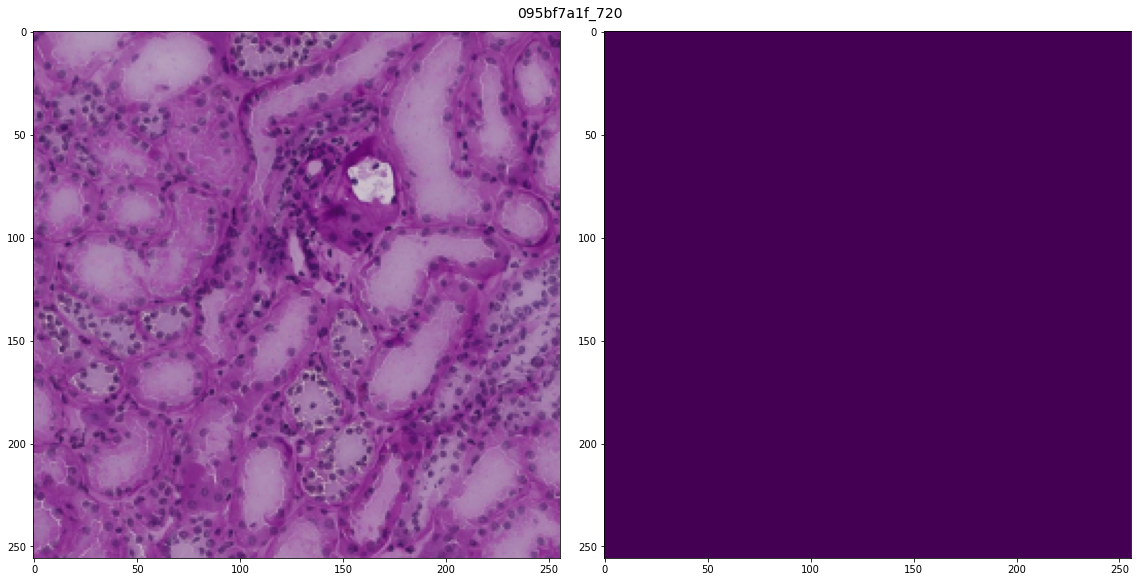

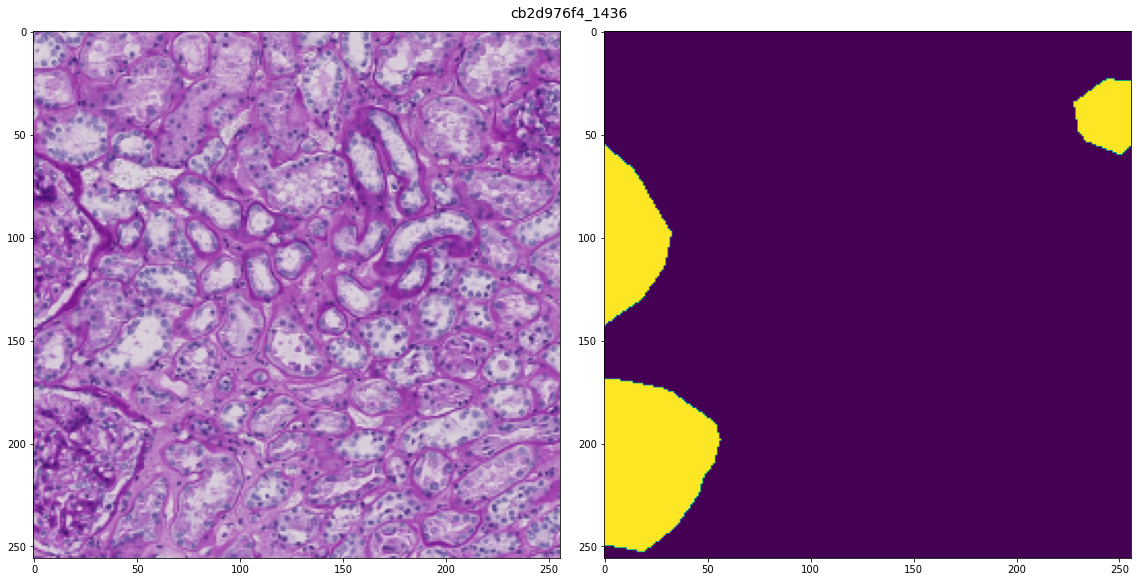

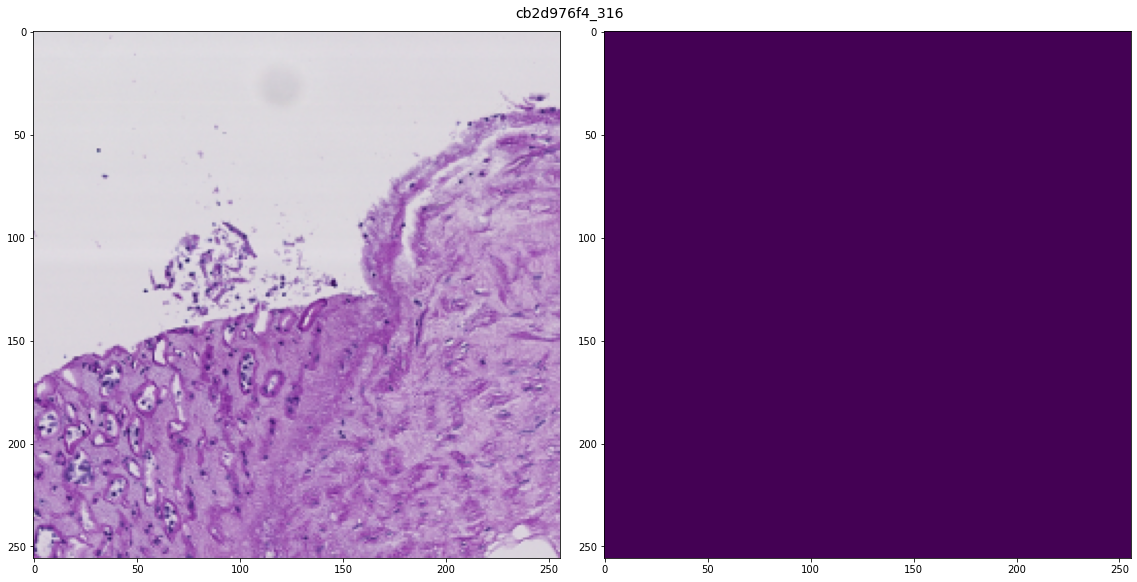

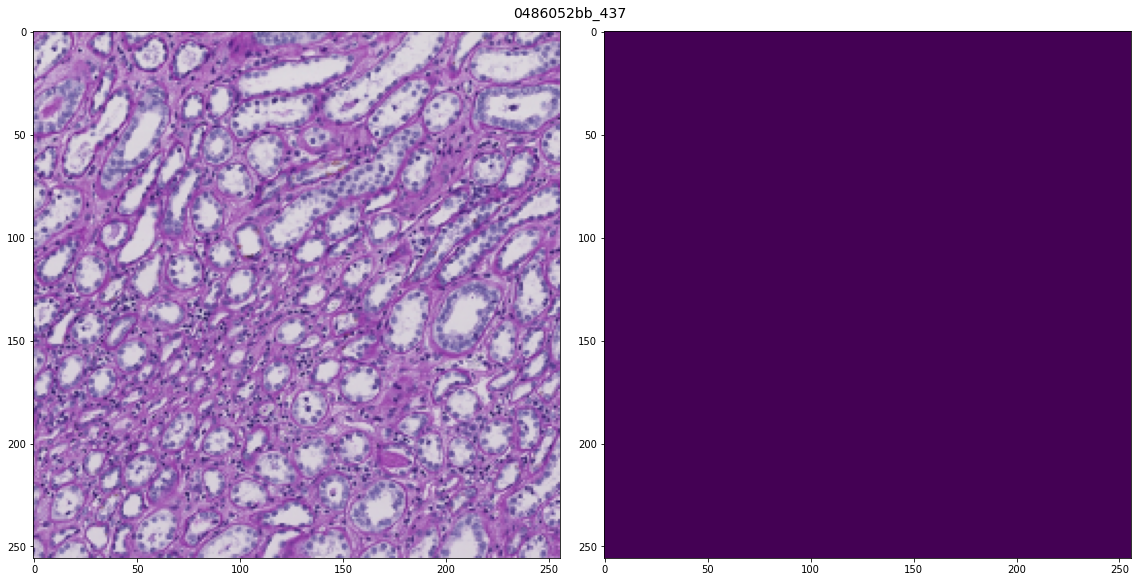

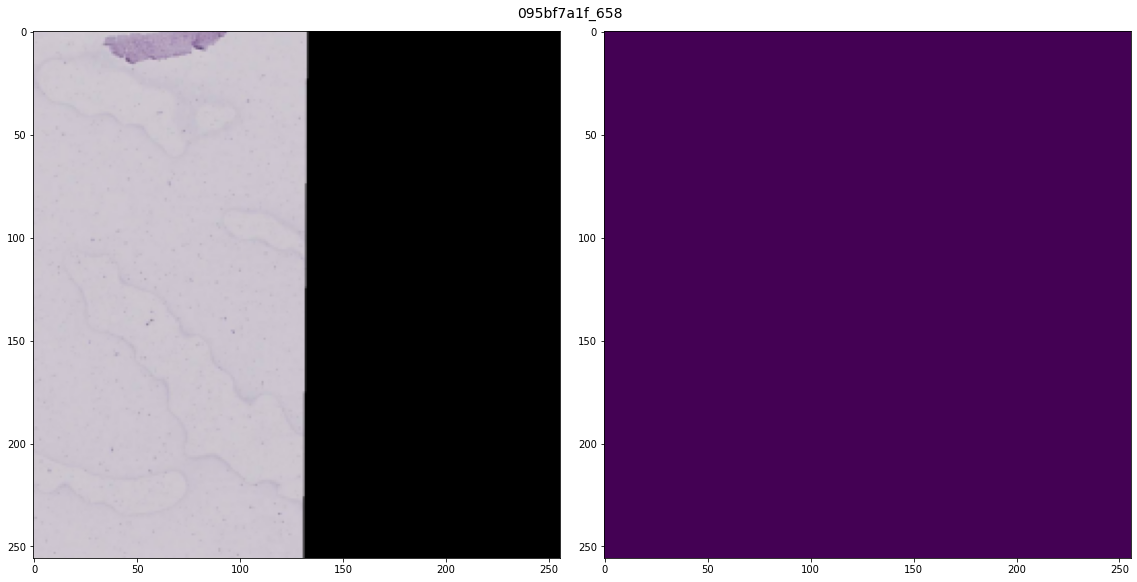

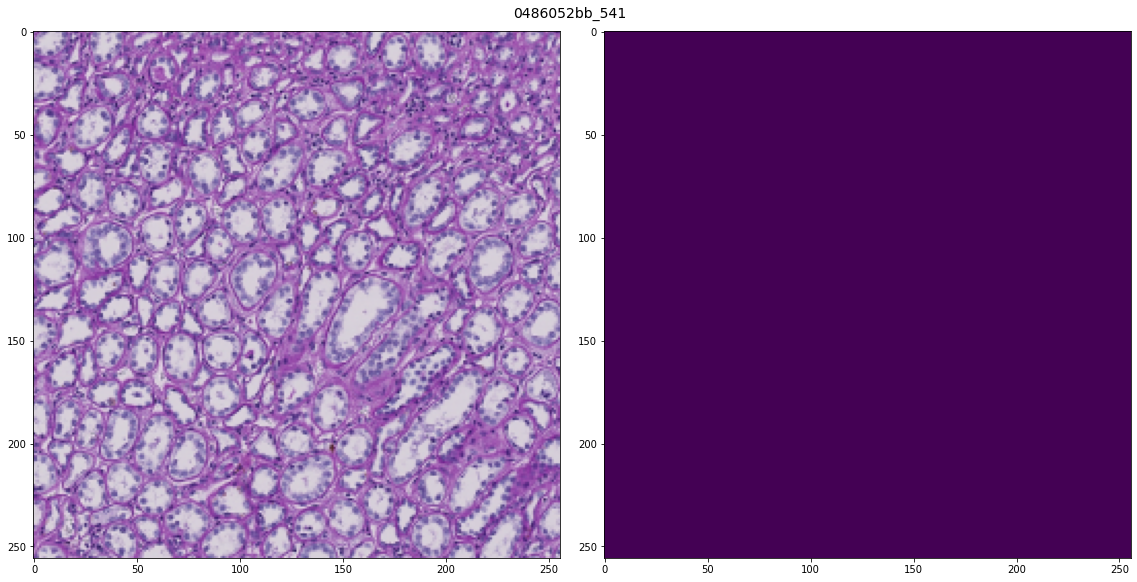

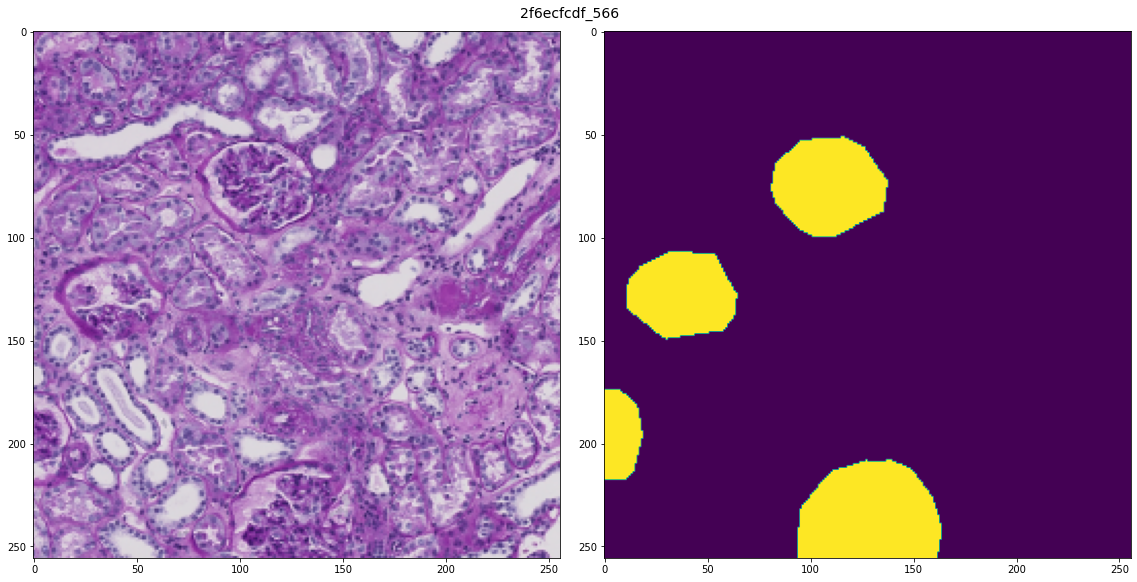

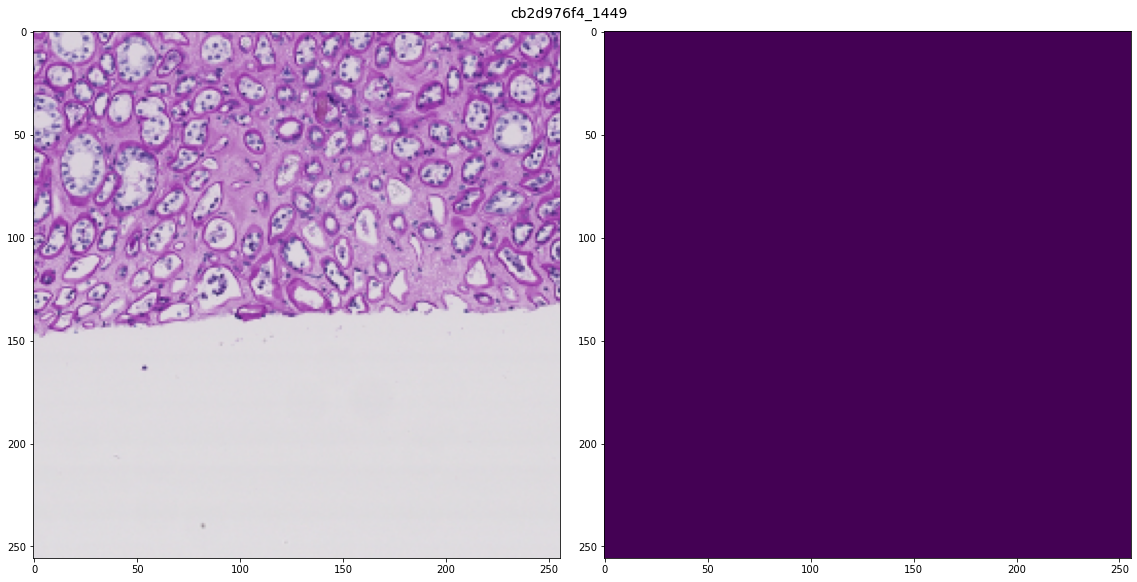

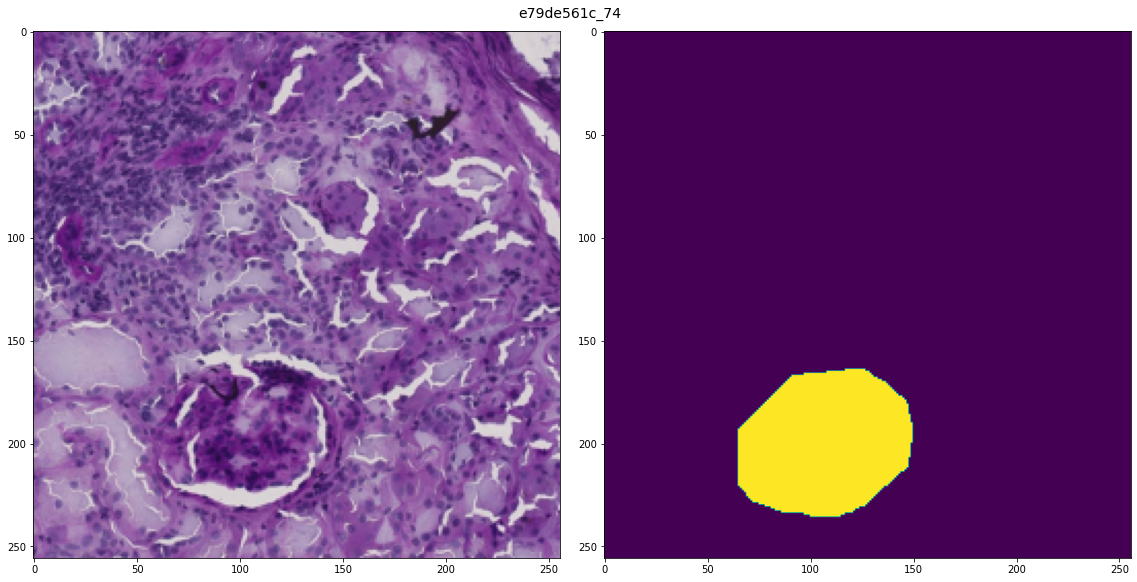

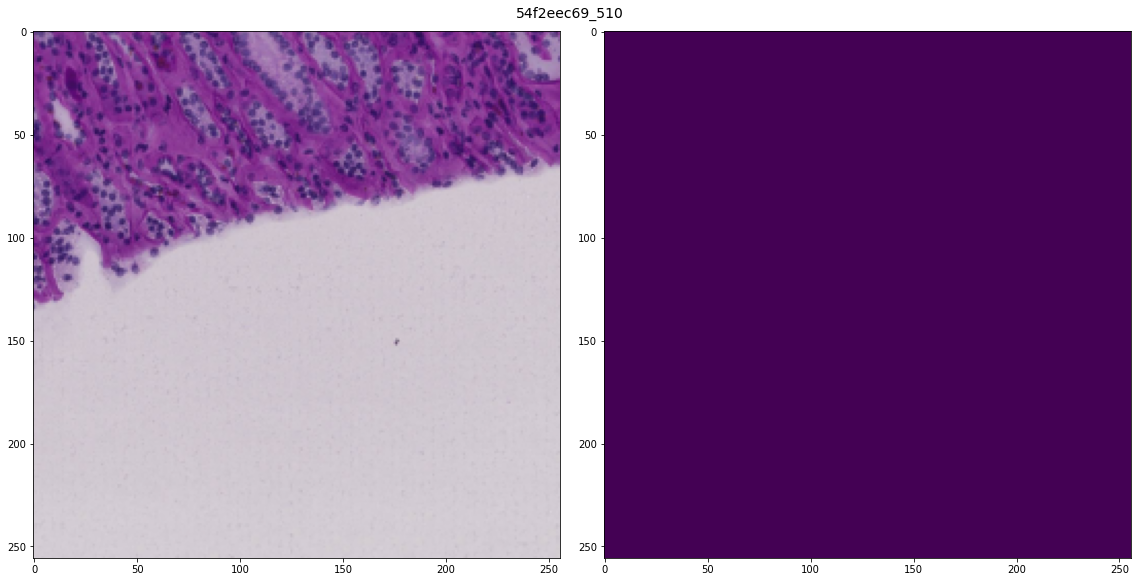

In [6]:
train_ds = tfds.load(data_name, data_dir=data_dir, split='train')

for data in train_ds.take(10):
  image = data['image']
  mask = data['mask']
#   wrapped_image = image * mask
#   wrapped_image_inv = image * (1 ^ mask)
  show_image(image, mask,
             title=data['id'])

In [7]:
size = TRAIN_IMAGE_SIZE

with strategy.scope():
  model = sm.Unet(BACKBONE, classes=1, activation='sigmoid',
                  input_shape=(size, size, 3))
  
  optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
  loss = sm.losses.DiceLoss()
  metrics = [sm.metrics.IOUScore(threshold=THRESHOLD),
             sm.metrics.FScore(threshold=THRESHOLD)]
  
  model.compile(optimizer, loss, metrics)

In [8]:
def preprocess(data):
  img = data['image']
  img = tf.cast(img, 'float32')
  msk = data['mask']
  msk = tf.cast(msk, 'float32')
  return img, msk

train_ds = tfds.load(data_name, data_dir=data_dir, split='train')
train_ds = (train_ds.map(preprocess, -1)
                    .shuffle(5000)
                    .repeat(-1)
                    .batch(BATCH_SIZE, drop_remainder=True)
                    .prefetch(-1))

In [ ]:
model.fit(train_ds,
         steps_per_epoch=STEPS_PER_EPOCH,
         epochs=EPOCHS,)

Epoch 1/100
